## Predicting House Price

In [276]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sb
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import os
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p

#Set decimals to 3
%precision 3

'%.3f'

In [277]:
#Read dataset
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [278]:
#Review dataset
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [279]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [280]:
#Review dataset size and shapes
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

### Data Back Up

In [281]:
#take a back up copy of dataset
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

### Handling Outliers

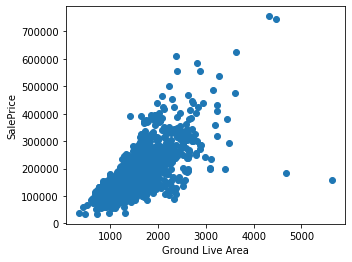

In [282]:
#Plot the outliers
plt.figure(figsize=(5,4))
plt.scatter(x=df_train['GrLivArea'], y=df_train['SalePrice'])
plt.xlabel('Ground Live Area')
plt.ylabel('SalePrice')
plt.show();

In [283]:
df_train.shape

(1460, 81)

In [284]:
#Delete the outliers
delidx = df_train[df_train['GrLivArea']>4000].index
df_train = df_train.drop(delidx, axis=0)
df_train.shape

(1456, 81)

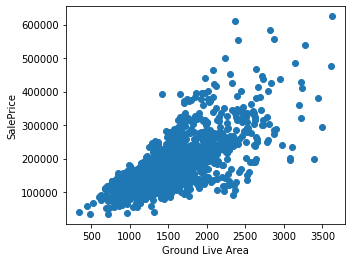

In [285]:
#review outliers removal
plt.figure(figsize=(5,4))
plt.scatter(x=df_train['GrLivArea'], y=df_train['SalePrice'])
plt.xlabel('Ground Live Area')
plt.ylabel('SalePrice')
plt.show();

### Capture Total Number of rows in Train and Test

In [286]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
ntrain, ntest

(1456, 1459)

### Target Setup

In [287]:
#Target column is identified as House SalePrice
y = df_train['SalePrice'].values

In [288]:
#Drop column id as that do not contribute to calculate SalePrice
srs_testid = df_test['Id'] #Take backup of testid for final submission file

df_train.drop('Id', inplace=True, axis=1)
df_test.drop('Id', inplace=True, axis=1)

#Validate column reduction
df_train.shape, df_test.shape

((1456, 80), (1459, 79))

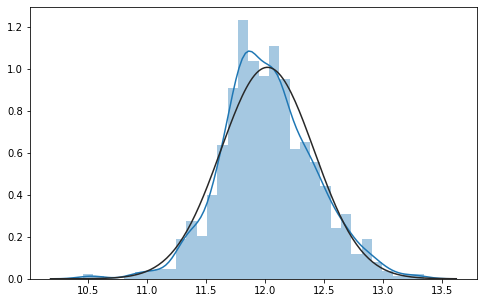

In [289]:
#Visualize target data
plt.figure(figsize=(8,5))
sb.distplot(y_train, fit=norm)
plt.show();

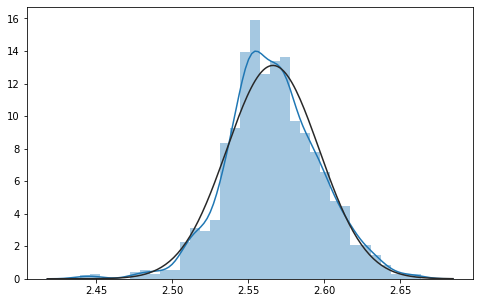

In [290]:
#Since its not normalized taking log1p to normalize it
plt.figure(figsize=(8,5))
sb.distplot(np.log1p(y_train), fit=norm)
plt.show();

In [291]:
#As the graph now shown to be normalized, Hence transforming yvalue to log1p
y_train = np.log1p(y_train)

### Building All Data

In [292]:
#Concate both train and test dataset for data transformation
df_alldata = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

#Review all data
df_alldata.shape

(2915, 80)

In [293]:
#drop target column SalePrice from all data
df_alldata.drop('SalePrice', 
               inplace=True,
               axis=1)

In [294]:
df_alldata.head(3)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008


## Data Munging

In [295]:
df_alldata.shape

(2915, 79)

In [296]:
#Remove columns were data is less than 90%
df_alldata_copy = df_alldata.copy()
df_alldata = df_alldata.dropna(thresh=len(df_alldata)*0.9, axis=1)
print('No. of columns dropped -', df_alldata_copy.shape[1]-df_alldata.shape[1])

No. of columns dropped - 6


In [297]:
c1 = df_alldata_copy.columns
c2 = df_alldata.columns
dcols = [col for col in c1 if col not in c2]
print('Columns dropped:', dcols)

Columns dropped: ['Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'MiscFeature', 'PoolQC']


In [298]:
df_alldata.shape

(2915, 73)

## Handling Missing Values

In [299]:
#Find null values in dataset
alldata_na = df_alldata.isnull().sum()
alldata_na = alldata_na[alldata_na>0]
alldata_na = alldata_na.sort_values(ascending=False)
print('No of columns with nulls: ', len(alldata_na))

No of columns with nulls:  28


In [300]:
#For selected columns below impute missing values with 'None'
nonecols=['GarageType','GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType','MSSubClass']

for col in nonecols:
    df_alldata[col] = df_alldata[col].fillna('None')

In [301]:
#For selected columns below impute missing values with 0
zerocols = ['GarageYrBlt','GarageArea','GarageCars', 'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','MasVnrArea']

for col in zerocols:
    df_alldata[col] = df_alldata[col].fillna(0)

In [302]:
#For selected columns below fill null with mode
modecols=['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']

for col in modecols:
    df_alldata[col] = df_alldata[col].fillna(df_alldata[col].mode()[0])

In [303]:
#Drop the Utilities column
df_alldata.drop('Utilities', inplace=True, axis=1)

In [304]:
#Impute value 'Typ'
df_alldata['Functional'] = df_alldata.fillna('Typ')

In [305]:
#Lookout for missing null values again
nas = df_alldata.isnull().sum()
nas = nas[nas>0]
nas

Series([], dtype: int64)

In [306]:
#Add new column TotalSF
df_alldata['TotalSF'] = df_alldata['TotalBsmtSF'] + df_alldata['1stFlrSF'] + df_alldata['2ndFlrSF']

In [307]:
#Drop noise columns
dropcols = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
df_alldata.drop(dropcols, inplace=True, axis=1)

In [308]:
#Convert these cols to numerical
df_alldata['Functional'] = df_alldata['Functional'].astype(float)

---

In [309]:
#Selecting numerical features
num_feats = df_alldata.select_dtypes(exclude='object').columns
num_feats

Index(['3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath',
       'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath',
       'Functional', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'KitchenAbvGr', 'LotArea', 'LowQualFinSF', 'MSSubClass',
       'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd', 'WoodDeckSF',
       'YearBuilt', 'YearRemodAdd', 'YrSold', 'TotalSF'],
      dtype='object')

In [310]:
catg_feats = df_alldata.dtypes[df_alldata.dtypes == 'object'].index
catg_feats

Index(['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Foundation',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating',
       'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope',
       'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'Neighborhood',
       'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType',
       'Street'],
      dtype='object')

In [311]:
#Before onehot encoding
df_beforeonehot = df_alldata.copy()

In [312]:
df_alldata.shape

(2915, 70)

## Perform One hot Encoding

In [313]:
#Actual onehot encoding avoiding dummy variable trap
for col in catg_feats:
    df_temp = df_alldata[col]
    df_temp = pd.DataFrame(df_temp)
    df_temp = pd.get_dummies(df_temp, prefix = col)
    temp = df_temp.columns[0] #Delete one dummy variable
    df_temp.drop(temp, inplace=True, axis=1)
    df_alldata = pd.concat([df_alldata, df_temp], axis=1).reset_index(drop=True)
    df_alldata.drop(col, inplace=True, axis=1) #Delete actual column from dataframe

In [314]:
df_alldata.shape

(2915, 231)

### Skew data to normalize feature values

In [315]:
skew_feats = df_alldata[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skew_feats = skew_feats[skew_feats>0.5]
print('No of Features to be Skewed: ', len(skew_feats))
print(skew_feats[:10])

No of Features to be Skewed:  24
MiscVal          21.932147
PoolArea         18.701829
LotArea          13.123758
LowQualFinSF     12.080315
3SsnPorch        11.368094
KitchenAbvGr      4.298845
BsmtFinSF2        4.142863
EnclosedPorch     4.000796
ScreenPorch       3.943508
BsmtHalfBath      3.942892
dtype: float64


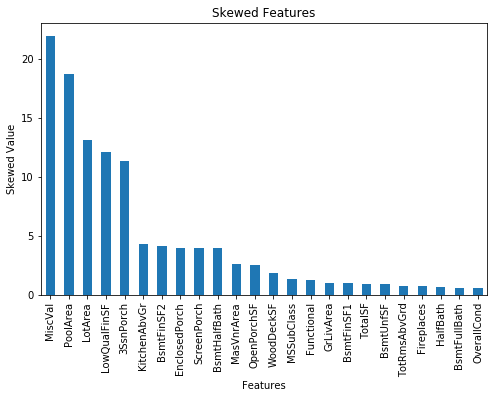

In [316]:
plt.figure(figsize=(8,5))
skew_feats.plot(kind='bar')
plt.title('Skewed Features')
plt.xlabel('Features')
plt.ylabel('Skewed Value')
plt.show()

In [317]:
#Perform Box Cox Transformation on selected features having skew value > 0.5
Lambda=0.15
for col in skew_feats.index:
    df_alldata[col] = boxcox1p(df_alldata[col], Lambda)
    
print('No of Features Skewed: ',skew_feats.shape[0])

No of Features Skewed:  24


## Building Training and Test Set

In [318]:
df_train = df_alldata[:ntrain]
df_test = df_alldata[ntrain:]

In [319]:
#X value
X = df_train.values
df_train.shape

(1456, 231)

In [320]:
#Y value
y.shape

(1456,)

In [321]:
#Test set
df_test.shape

(1459, 231)

### Building Model Validation Functions

In [322]:
#Defining cross validation strategy
cross_val = KFold(n_splits=10, shuffle=True, random_state=42)

### Building Function for Submission

In [323]:
def Submission(prediction):
    df_pred = pd.DataFrame({'Id':srs_testid, 'SalePrice':prediction})
    print('Sample Prediction:', prediction[:5])
    
    #Defining file name
    tday = datetime.today()
    tm = str(tday.date().day)+str(tday.date().month)+str('_')+str(tday.time().hour)+str(tday.time().minute)+str(tday.time().second)
    fn = 'Submission_'
    fn = str(fn)+str(tm)+str('.csv')
    
    #Saving prediction to csv
    df_pred.to_csv(fn, index=False)
    print('Submission file saved to', os.path.realpath(fn))

### Function to save score values

In [324]:
cols = ['Model', 'Train_RMSE', 'Test_RMSE', 'Comments']
df_model = pd.DataFrame(columns=cols)

In [325]:
def rmse_train(df_model, model, x, y, comments='Comments'):
    
    rmse = np.sqrt(-cross_val_score(model, x, y, cv=cross_val, scoring='neg_mean_squared_error', n_jobs=-1))
    rmse = rmse.mean()
    
    #Create dictionary
    dict_score = {}
    dict_score['Model'] = model.__class__.__name__
    dict_score['Train_RMSE'] = rmse
    dict_score['Test_RMSE'] = 'NA'
    dict_score['Comments'] = comments
    
    #Create dataframe with values
    df_temp = pd.DataFrame(dict_score, index=[0])
    
    #Append dataframe
    df_model = df_model.append(df_temp)
    df_model = df_model.reset_index(drop=True)
    
    return df_model

In [326]:
def rmse_test(df_model,modelname, y, y_pred, comments='Comments'):
    
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    #Create dictionary
    dict_score = {}
    dict_score['Model'] = modelname
    dict_score['Train_RMSE'] = 'NA'
    dict_score['Test_RMSE'] = rmse
    dict_score['Comments'] = comments
    
    #Create dataframe with values
    df_temp = pd.DataFrame(dict_score, index=[0])
    
    #Append dataframe
    df_model = df_model.append(df_temp)
    df_model = df_model.reset_index(drop=True)
    
    return df_model

In [369]:
def calc_rmse(model, df_model=df_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, comments='Comments'):
    
    #Calculate train rmse
    rmse_train = np.sqrt(-cross_val_score(model, X_train, y_train, cv=cross_val, scoring='neg_mean_squared_error', n_jobs=-1))
    rmse_train = rmse_train.mean()
    
    #Fit the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Calculate test rmse
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    
    #Create dictionary
    dict_score = {}
    dict_score['Model'] = model.__class__.__name__
    dict_score['Train_RMSE'] = rmse_train
    dict_score['Test_RMSE'] = rmse_test
    dict_score['Comments'] = comments
    
    #Create dataframe with values
    df_temp = pd.DataFrame(dict_score, index=[0])
    
    #Append dataframe
    df_model = df_model.append(df_temp)
    df_model = df_model.reset_index(drop=True)
    
    return df_model

---

### Building Model

In [328]:
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge, ElasticNet, ElasticNetCV
from sklearn.model_selection import KFold, train_test_split, ShuffleSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import lightgbm as lgbm

In [329]:
#Split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [330]:
print('Training set size:', X_train.shape[0])
print('Test set size:', X_test.shape[0])

Training set size: 1164
Test set size: 292


### Scaling data using Robust Scaler

In [331]:
rscaler = RobustScaler()
X_train = rscaler.fit_transform(X_train) #Scaled train data
X_test = rscaler.transform(X_test) #Scaled dev data
test_set = rscaler.transform(df_test.values) #Scale validation set

In [332]:
alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 2, 10, 20, 50]

In [360]:
#Building Lasso Model
lcv = LassoCV(alphas=alphas2, random_state=42, cv=cross_val, n_jobs=-1, max_iter=10000)

In [361]:
lcv.fit(X_train, y_train)

LassoCV(alphas=[99.001, 99.002, 99.001, 99.01], copy_X=True,
        cv=KFold(n_splits=10, random_state=42, shuffle=True), eps=0.001,
        fit_intercept=True, max_iter=10000, n_alphas=100, n_jobs=-1,
        normalize=False, positive=False, precompute='auto', random_state=42,
        selection='cyclic', tol=0.0001, verbose=False)

In [362]:
lcv.alpha_

99.001

In [359]:
alphas2 = [99.001, 99.002, 99.0010, 99.010]

In [363]:
regressor_lasso = Lasso(alpha=99.001, random_state=42, max_iter=10000)
# regressor_lasso.fit(x_train,y_train)

In [368]:
regressor_lasso.fit(X_train,y_train)

Lasso(alpha=99.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

In [366]:
X_train.shape, y_train.shape

((1164, 231), (1164,))

In [370]:
df_model = calc_rmse(regressor_lasso, comments='Lasso Model output')
df_model

,Model,Train_RMSE,Test_RMSE,Comments
0,Lasso,25661.074819,22300.67521,Lasso Model output


In [164]:
df_model = rmse_train(df_model, regressor_lasso, x_train, y_train, 'Basic Lasso Model')
df_model

,Model,Train_RMSE,Test_RMSE,Comments
0,Lasso,0.112209,NA,Basic Lasso Model
1,Lasso,0.112148,NA,Basic Lasso Model


In [180]:
pred_lasso = regressor_lasso.predict(x_train)
modelname = 'Lasso'
df_model = rmse_test(df_model, modelname, y_train, pred_lasso, 'Basic Lasso Model Test')
df_model

,Model,Train_RMSE,Test_RMSE,Comments
0,Lasso,0.112209,NA,Basic Lasso Model
1,Lasso,0.112148,NA,Basic Lasso Model
2,Lasso,NA,0.0947991,Basic Lasso Model Test


In [186]:
#Fit lasso regressor model
regressor_lasso.fit(X_train, y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

In [187]:
df_model = rmse_train(df_model, regressor_lasso, X_train, y_train, 'Lasso model with train test split')
df_model

,Model,Train_RMSE,Test_RMSE,Comments
0,Lasso,0.112209,NA,Basic Lasso Model
1,Lasso,0.112148,NA,Basic Lasso Model
2,Lasso,NA,0.0947991,Basic Lasso Model Test
3,Lasso,0.115885,NA,Lasso model with train test split


In [188]:
df_model = rmse_test(df_model, 'Lasso', y_test, regressor_lasso.predict(X_test), 'Lasso train test split - Test')
df_model

,Model,Train_RMSE,Test_RMSE,Comments
0,Lasso,0.112209,NA,Basic Lasso Model
1,Lasso,0.112148,NA,Basic Lasso Model
2,Lasso,NA,0.0947991,Basic Lasso Model Test
3,Lasso,0.115885,NA,Lasso model with train test split
4,Lasso,NA,0.118247,Lasso train test split - Test


In [203]:
x_train.shape, y_train.shape

((1456, 231), (1164,))

In [202]:
df_model = calc_rmse(df_model, model=regressor_lasso, comments='Train test split')
df_model

ValueError: Found input variables with inconsistent numbers of samples: [1456, 1164]

### Building Ridge Model

In [189]:
rcv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=cross_val)

In [190]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-04, 3.e-04, 6.e-04, 1.e-03, 3.e-03, 6.e-03, 1.e-02, 3.e-02,
       6.e-02, 1.e-01, 3.e-01, 6.e-01, 1.e+00, 2.e+00, 1.e+01, 2.e+01,
       5.e+01]),
        cv=KFold(n_splits=10, random_state=42, shuffle=True),
        fit_intercept=True, gcv_mode=None, normalize=False,
        scoring='neg_mean_squared_error', store_cv_values=False)

In [191]:
rcv.alpha_

10.0

In [192]:
regressor_ridge = Ridge(alpha=10, random_state=42, max_iter=10000)

In [193]:
regressor_ridge.fit(X_train, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=42, solver='auto', tol=0.001)

---

## Appendix

In [ ]:
def rmse_train(df_model, model, x, y, comments='Comments'):
    
    rmse = np.sqrt(-cross_val_score(model, x, y, cv=cross_val, scoring='neg_mean_squared_error', n_jobs=-1))
    rmse = rmse.mean()
    
    #Create dictionary
    dict_score = {}
    dict_score['Model'] = model.__class__.__name__
    dict_score['Train_RMSE'] = rmse
    dict_score['Test_RMSE'] = 'NA'
    dict_score['Comments'] = comments
    
    #Create dataframe with values
    df_temp = pd.DataFrame(dict_score, index=[0])
    
    #Append dataframe
    df_model = df_model.append(df_temp)
    df_model = df_model.reset_index(drop=True)
    
    return df_model